# Import packages and modules

In [4]:
!pip install vadersentiment 
!pip install afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from afinn import Afinn
import pandas as pd
import nltk
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

     |████████████████████████████████| 133kB 6.7MB/s 
     |████████████████████████████████| 61kB 4.5MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp37-none-any.whl size=53452 sha256=d1283a24c2ee94250012748ca2b0b26d72e3dcb0d314b7ddb1ccd6996ce80d60
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [7]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
stopwords=nltk.corpus.stopwords.words("english")
wn=nltk.WordNetLemmatizer()
swn= nltk.corpus.sentiwordnet

# Understanding the Data

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

Content:

It contains the following 6 fields:

1.target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

2.ids: The id of the tweet ( 2087)

3.date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4.flag: The query (lyx). If there is no query, then this value is NO_QUERY.

5.user: the user that tweeted (robotickilldozr)

6.text: the text of the tweet (Lyx is cool)

In [9]:
Data_encoder="ISO-8859-1"
df = pd.read_csv("training.csv",encoding=Data_encoder,header=None)
df.columns=['target','ids','date','flag','user_name','body_text']
dataset=df.copy()
dataset.head()

,target,ids,date,flag,user_name,body_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   target     1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user_name  1600000 non-null  object
 5   body_text  1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
dataset.isnull().sum()

target       0
ids          0
date         0
flag         0
user_name    0
body_text    0
dtype: int64

In [12]:
dataset.shape

(1600000, 6)

In [13]:
dataset["target"].unique()

array([0, 4])

In [14]:
dataset["target"].nunique()

2

# Cleaning the data

In [15]:
#replacing all the positive sentiment with target value of 1
dataset["target"]=dataset["target"].replace(4,1)
dataset["target"].unique()

array([0, 1])

In [16]:
#seperating target and text of positie sentiment from the dataset
pos_dataset=dataset[dataset["target"]==1][["body_text","target"]]
pos_dataset.head()               

,body_text,target
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1


In [17]:
#seperating target and text of negative sentiment from the dataset
neg_dataset=dataset[dataset["target"]==0][["body_text","target"]]
neg_dataset.head()

,body_text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [18]:
#joining both the dataframes
working_dataset=pd.concat([neg_dataset,pos_dataset])
working_dataset.head()

,body_text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [19]:
#This function removes the url and numbers present in the text
def clean_url(text):
  text=re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text)
  text=re.sub('[0-9]+','',text)
  return text

In [20]:
#This function  will tokenize the text
def tokenize(text):
  text=''.join([char.lower() for char in text if char not in string.punctuation])
  tokens=re.split('\W+',text)
  text=[wn.lemmatize(word) for word in tokens if word not in stopwords]
  return text

In [30]:
#This function  finds the capital letters in the text
def caps(text):
  cap_count=sum([1 for char in text if char.isupper() ])
  if (len(text)-text.count(" "))==0:
      return 0
  else:
    return round(cap_count/(len(text)-text.count(" ")),3)*100

In [22]:
#This function  prepares the text to be used to form word cloud
def wordcloud(text):
  text=''.join([char.lower() for char in text if char not in string.punctuation])
  tokens=re.split('\W+',text)
  text=" ".join([wn.lemmatize(word) for word in tokens if word not in stopwords])
  return text

In [23]:
#just removing the url and the numbers in the text
working_dataset["clean_text"]=working_dataset["body_text"].apply(lambda x: clean_url(x))
working_dataset.head()

,body_text,target,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,@switchfoot s a bummer. You shoulda got Davi...
1,is upset that he can't update his Facebook by ...,0,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...,0,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",0,"@nationwideclass no, it's not behaving at all...."


# Word Cloud

In [24]:
#calling function that prepares the text for creating word cloud
working_dataset["word_cloud"]=working_dataset["clean_text"].apply(lambda x: wordcloud(x))

## Word cloud: Positive sentiment

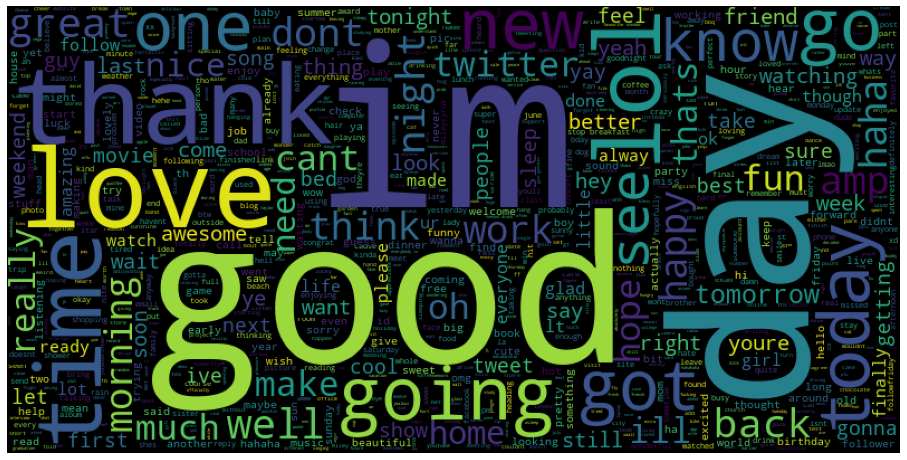

In [25]:
data_pos=working_dataset[working_dataset["target"]==1]["word_cloud"]
wc=WordCloud(max_words=1000,width=800,height=400,collocations=False).generate(" ".join(data_pos))
plt.figure(figsize=(16,16))
plt.axis("OFF")
plt.imshow(wc)

## Word cloud: Negative sentiment

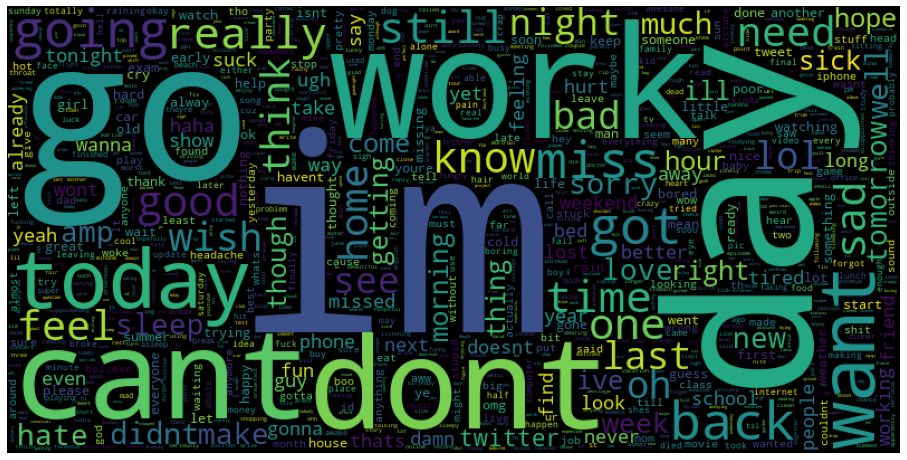

In [26]:
data_neg=working_dataset[working_dataset["target"]==0]["word_cloud"]
wc=WordCloud(max_words=1000,width=800,height=400,collocations=False).generate(" ".join(data_neg))
plt.figure(figsize=(16,16))
plt.axis("OFF")
plt.imshow(wc)

# Feature Engineering

It is the process of creating new features or transforming existing features to get most out of the data

Creating new features:

1. Length of the text
2. Percentage of text capitalized

In [31]:
#length of the text
working_dataset["text_length"]=working_dataset["clean_text"].apply(lambda x: len(x)-x.count(" "))

#percentage of capital letters
working_dataset["capital%"]=working_dataset["clean_text"].apply(lambda x: caps(x))
working_dataset.head()

,body_text,target,clean_text,word_cloud,text_length,capital%
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,@switchfoot s a bummer. You shoulda got Davi...,switchfoot bummer shoulda got david carr third...,61,9.8
1,is upset that he can't update his Facebook by ...,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...,90,3.3
2,@Kenichan I dived many times for the ball. Man...,0,@Kenichan I dived many times for the ball. Man...,kenichan dived many time ball managed save res...,69,5.8
3,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire,37,0.0
4,"@nationwideclass no, it's not behaving at all....",0,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving im mad cant see,90,1.1


Length of text histogram

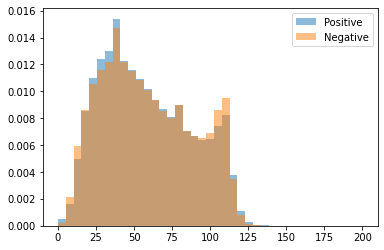

In [32]:
#creating histogram to check the distribution
bins = np.linspace(0,200,40)
plt.hist(working_dataset[working_dataset["target"]==1]["text_length"],bins,density=True,alpha=0.5,label="Positive")
plt.hist(working_dataset[working_dataset["target"]==0]["text_length"],bins,density=True,alpha=0.5,label="Negative")
plt.legend(loc="upper right")
plt.show()

Percentage of capital letters histogram

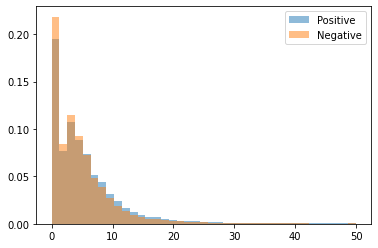

In [33]:
bins = np.linspace(0,50,40)
plt.hist(working_dataset[working_dataset["target"]==1]["capital%"],bins,density=True,alpha=0.5,label="Positive")
plt.hist(working_dataset[working_dataset["target"]==0]["capital%"],bins,density=True,alpha=0.5,label="Negative")
plt.legend(loc="upper right")
plt.show()

## Conclusion:
We see that the features created are not giving much insite to the data itself so we are not inclusing these when training the model

# Classifying sentiment with supervised learning

# Split the dataset

In [34]:
X=working_dataset[["clean_text"]]
y=working_dataset["target"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# Vectorize text

## Tfidf Vectorizer

In [35]:
tfidf_vect=TfidfVectorizer(analyzer=tokenize)
tfidf_vect_fit=tfidf_vect.fit(X_train["clean_text"])

tfidf_train=tfidf_vect_fit.transform(X_train["clean_text"])
tfidf_test=tfidf_vect_fit.transform(X_test["clean_text"])

## Count Vectorizer

In [36]:
count_vect=CountVectorizer(analyzer=tokenize)
count_vect_fit=count_vect.fit(X_train["clean_text"])

count_train=count_vect_fit.transform(X_train["clean_text"])
count_test=count_vect_fit.transform(X_test["clean_text"])

# Model training and Performance Evaluation

In [37]:
#this function for evaluating the model
def model_evaluate(y_pred):
  print(classification_report(y_test,y_pred))
  con_mat=confusion_matrix(y_test,y_pred)
  group_name=["True neg","False pos","False neg", "True pos"]
  group_count=["{}".format(value) for value in con_mat.flatten()]
  group_percentage=["{0:.2%}".format(value) for (value) in (con_mat.flatten()/np.sum(con_mat))]

  label=[f"{v1}\n{v2}\n{v3}" for (v1,v2,v3) in zip(group_name,group_count,group_percentage)]
  label=np.asarray(label).reshape(2,2)

  sns.heatmap(con_mat,annot=label,fmt='',cmap="flare")
  plt.xlabel("Predicted values", fontdict = {'size':12}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':12}, labelpad = 10)

## Naive Bayes

### Naive Bayes with Tfidf Vectorizer

              precision    recall  f1-score   support

           0       0.77      0.79      0.78    160000
           1       0.78      0.76      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.78      0.77      0.77    320000
weighted avg       0.78      0.77      0.77    320000



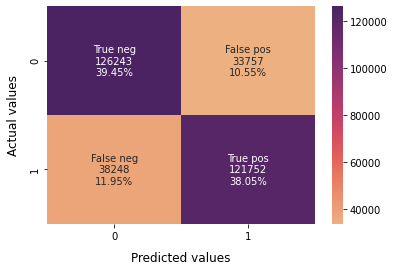

In [38]:
BNB=BernoulliNB()
#train the model
BNB_tfidf=BNB.fit(tfidf_train,y_train)
#get model prediction for test data
y_pred=BNB_tfidf.predict(tfidf_test)

model_evaluate(y_pred)


### Naive Bayes with Count Vectorizer

              precision    recall  f1-score   support

           0       0.77      0.79      0.78    160000
           1       0.78      0.76      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.78      0.77      0.77    320000
weighted avg       0.78      0.77      0.77    320000



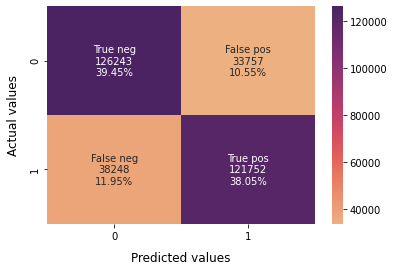

In [39]:
BNB=BernoulliNB()
#train the model
BNB_count=BNB.fit(count_train,y_train)
#get model prediction for test data
y_pred=BNB_count.predict(count_test)

model_evaluate(y_pred)


## SVM

### SVM with Tfidf Vectorizer

              precision    recall  f1-score   support

           0       0.78      0.77      0.78    160000
           1       0.77      0.79      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



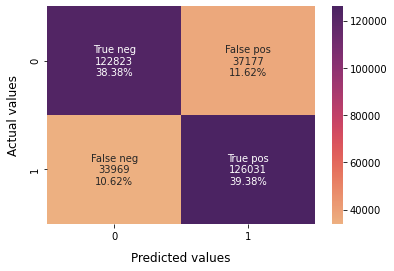

In [40]:
svm=LinearSVC()


#train the model
svm_tfidf=svm.fit(tfidf_train,y_train)
#get the prediction for test data
y_pred=svm_tfidf.predict(tfidf_test)

model_evaluate(y_pred)

### SVM with Count Vectorizer

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.77      0.77      0.77    160000
           1       0.77      0.78      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



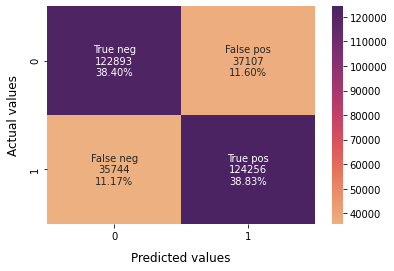

In [41]:
svm=LinearSVC()
#train the model
svm_count=svm.fit(count_train,y_train)
#get model prediction for test data
y_pred=svm_count.predict(count_test)

model_evaluate(y_pred)


## Logistic Regression

### Logistic Regression with Tfidf Vectorizer

              precision    recall  f1-score   support

           0       0.80      0.77      0.78    160000
           1       0.78      0.80      0.79    160000

    accuracy                           0.78    320000
   macro avg       0.79      0.78      0.78    320000
weighted avg       0.79      0.78      0.78    320000



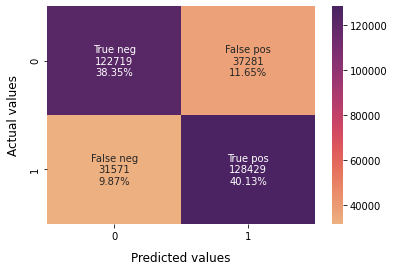

In [42]:
lr=LogisticRegression(n_jobs=-1)

#train the model
lr_tfidf=lr.fit(tfidf_train,y_train)
#get model prediction for test data
y_pred=lr_tfidf.predict(tfidf_test)

model_evaluate(y_pred)

### Logistic Regression with Count Vectorizer

              precision    recall  f1-score   support

           0       0.80      0.75      0.77    160000
           1       0.77      0.81      0.79    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



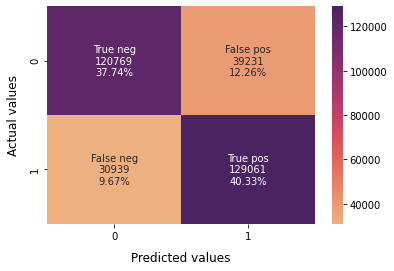

In [43]:
lr=LogisticRegression(n_jobs=-1)

#train the model
lr_count=lr.fit(count_train,y_train)
#get model prediction for test data
y_pred=lr_count.predict(count_test)

model_evaluate(y_pred)

## Conclusion:

**With tfidf vectorizer:** Logistic Regression with tfidf vectorizer as input perfoms well when compared to SVM or Naive Bayes

**With count vectorizer:** Logistic Regression with count vectorizer as input perfoms well when compared to SVM or Naive Bayes 

Logistic Regression with tfidf vectorizer as input seems to be a better option

# Classifying sentiment with unsupervised learning

For this purpose we are using the Lexicon based classfication using the following:


1.   Text blob: The sentiment function of textblob returns two properties, polarity, and subjectivity. Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. 
2.   Vader Sentiment: The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).Positive sentiment : (compound score >= 0.05), neutral sentiment : (compound score > -0.05) and (compound score < 0.05) and negative sentiment : (compound score <= -0.05). Since we will be only classying positive and negative have to assign a threshold for postive and negative with a number within the range of -0.05 to 0.05
3.   Afinn: Sentiment score ranges from 5 to -5, where 5 is postive and -5 is negative. 

First the range is tweeked to get a better accuracy, which is done using the train data and for evaluation purpose where we will be using the test data 

# Adjusting range
 Here the range classifying positive and negative sentiment is adjusted

## Text Blob range adjustment

In [50]:
#this function tests the accuracy of the textblob
def textblob_accuracy(x,y):
  pos_count=0
  pos_correct=0
  neg_count=0
  neg_correct=0
  for (x,y) in zip(x["clean_text"],y):
    analyzer=TextBlob(x)
    #positive sentiment
    if y==1:
      if analyzer.sentiment.polarity>0:
        pos_correct+=1
      pos_count+=1

    #negative sentiment
    if y==0:
        if analyzer.sentiment.polarity<=0:
          neg_correct+=1
        neg_count+=1
  return "positive sentiment accuracy:{}% \nnegative sentiment accuracy:{}% \naverage accuracy:{}%".format(
    round((pos_correct*100/pos_count),3),round((neg_correct*100/neg_count),3), 
    (round((pos_correct*100/pos_count),3)+round((neg_correct*100/neg_count),3))/2)


In [51]:
result=textblob_accuracy(X_train,y_train)
print(result)

positive sentiment accuracy:55.33% 
negative sentiment accuracy:68.961% 
average accuracy:62.1455%


## Vader sentiment range adjustment

In [48]:
#this function tests the accuracy of the vader sentiment 
def vader_accuracy(x,y):
  pos_count=0
  pos_correct=0
  neg_count=0
  neg_correct=0
  analyzer=SentimentIntensityAnalyzer()
  for (x,y) in zip(x["clean_text"],y):
    vs=analyzer.polarity_scores(x)
    #positive sentiment
    if y==1:
      if vs['compound'] >0:
        pos_correct+=1
      pos_count+=1

    #negative sentiment 
    if y==1:
      if vs['compound']<= 0:
        neg_correct+=1
      neg_count+=1
 
  return "positive sentiment accuracy:{}% \nnegative sentiment accuracy:{}% \naverage accuracy:{}%".format(
    round((pos_correct*100/pos_count),3),round((neg_correct*100/neg_count),3), 
    (round((pos_correct*100/pos_count),3)+round((neg_correct*100/neg_count),3))/2)

In [49]:
result=vader_accuracy(X_train,y_train)
print(result)

positive sentiment accuracy:61.912% 
negative sentiment accuracy:38.088% 
average accuracy:50.0%


## Afinn range adjustment

In [54]:
#this function tests the accuracy of the afinn
def afinn_accuracy(x,y):
  pos_count=0
  pos_correct=0
  neg_count=0
  neg_correct=0
  af=Afinn()
  for (x,y) in zip (x["clean_text"],y):
    score=af.score(x)
    #postive sentiment
    if y==1:
      if score>=0:
        pos_correct+=1
      pos_count+=1

    #negative sentiment
    if y==0:
      if score<0:
        neg_correct+=1
      neg_count+=1

  return "positive sentiment accuracy:{}% \nnegative sentiment accuracy:{}% \naverage accuracy:{}%".format(
    round((pos_correct*100/pos_count),3),round((neg_correct*100/neg_count),3), 
    (round((pos_correct*100/pos_count),3)+round((neg_correct*100/neg_count),3))/2)
    

In [55]:
result=afinn_accuracy(X_train,y_train)
print(result)

positive sentiment accuracy:90.086% 
negative sentiment accuracy:40.495% 
average accuracy:65.2905%


# Evaluation

## Text blob Performance Evaluation

In [56]:
#this function tests the evaluation of the textblob range first initialized
def textblob_predict(x_test):
  prediction=[]
  for x in x_test["clean_text"]:
    analyzer=TextBlob(x)
    if analyzer.sentiment.polarity>0:
      prediction.append(1)
    elif analyzer.sentiment.polarity<=0:
      prediction.append(0)
  return prediction

              precision    recall  f1-score   support

           0       0.61      0.69      0.65    160000
           1       0.64      0.55      0.59    160000

    accuracy                           0.62    320000
   macro avg       0.62      0.62      0.62    320000
weighted avg       0.62      0.62      0.62    320000



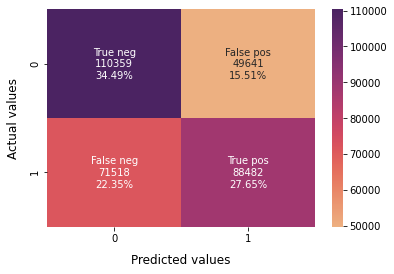

In [57]:
y_pred=textblob_predict(X_test)
model_evaluate(y_pred)

## Vader Sentiment Performance evaluation

In [58]:
#this function tests the evaluation of the vader sentiment range first initialized
def vader_predict(x_test):
  prediction=[]
  analyzer=SentimentIntensityAnalyzer()
  for x in x_test["clean_text"]:
    vs=analyzer.polarity_scores(x)
    if vs['compound'] >0:
      prediction.append(1)
    elif vs["compound"]<=0:
      prediction.append(0)
  return prediction

              precision    recall  f1-score   support

           0       0.64      0.68      0.66    160000
           1       0.66      0.62      0.64    160000

    accuracy                           0.65    320000
   macro avg       0.65      0.65      0.65    320000
weighted avg       0.65      0.65      0.65    320000



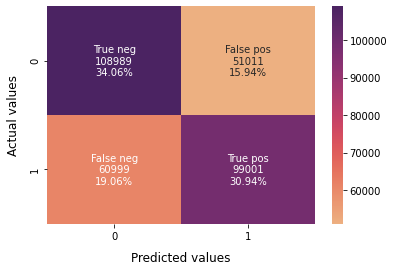

In [59]:
y_pred=vader_predict(X_test)
model_evaluate(y_pred)

## Afinn performance evaluation

In [60]:
#this function tests the evaluation of the afinn range first initialized
def afinn_predict(x_test):
  prediction=[]
  af=Afinn()
  for x in x_test["clean_text"]:
    score=af.score(x)
    if score>=0:
      prediction.append(1)
    elif score<0:
      prediction.append(0)
  return prediction

              precision    recall  f1-score   support

           0       0.81      0.41      0.54    160000
           1       0.60      0.90      0.72    160000

    accuracy                           0.65    320000
   macro avg       0.70      0.65      0.63    320000
weighted avg       0.70      0.65      0.63    320000



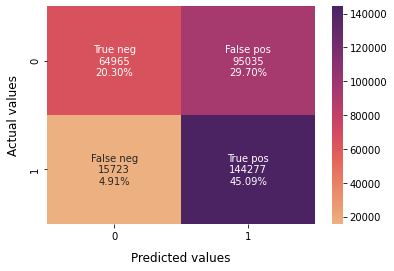

In [61]:
y_pred=afinn_predict(X_test)
model_evaluate(y_pred)

# Conclusion:

Affin perfoms fairly better than Vader and it performs really well when compared to TextBlob